### Kütüphaneler

In [17]:
import ultralytics
from ultralytics import YOLO
import cv2
from PIL import Image
from IPython.display import Video
import matplotlib.pyplot as plt
from IPython.display import display
import torch
ultralytics.checks()

import easyocr as ocr 
import cv2 
import numpy as np
import matplotlib.pyplot as plt

import sqlite3

Ultralytics YOLOv8.2.100  Python-3.12.4 torch-2.2.2+cpu CPU (Intel Core(TM) i5-8265U 1.60GHz)
Setup complete  (8 CPUs, 15.9 GB RAM, 216.6/339.8 GB disk)


### Eğitilmiş yolov8 Modelinin Yüklenmesi 

In [18]:
model = YOLO('runs/detect/train6/weights/best.pt')

### Test Görüntüsünün Yüklenmesi 

In [19]:
test_result = model.predict(source='test_data/test.jpeg')


image 1/1 c:\Users\havva\OneDrive\Desktop\plaka_tanima\test_data\test.jpeg: 544x640 1 LicensePlate, 129.8ms
Speed: 4.0ms preprocess, 129.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


In [20]:
# Ana görüntüyü yükle
img = Image.open('test_data/test.jpeg')

In [21]:
test_result = model.predict(img)


0: 544x640 1 LicensePlate, 156.1ms
Speed: 55.2ms preprocess, 156.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


In [22]:
img1 = test_result[0].plot()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = Image.fromarray(img1)
img1 = img1.resize((640,640))  # verisetinde resimlerin boyutu budur 

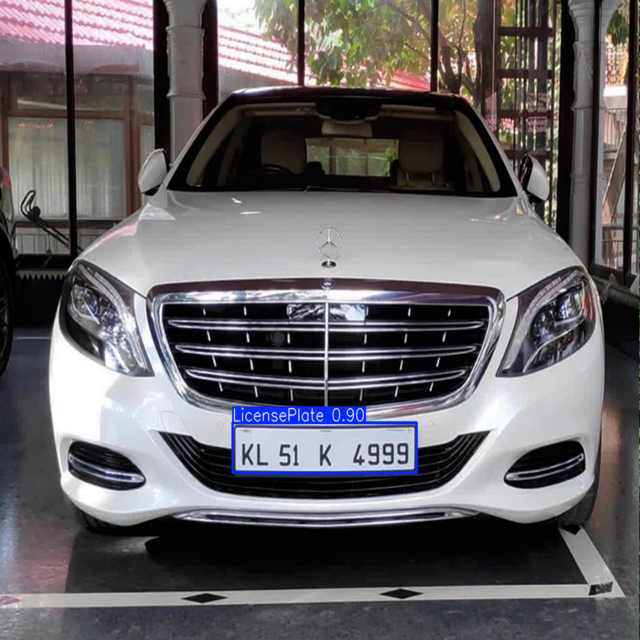

In [23]:
total_width = img1.width
max_height = img1.height  # max() yerine doğrudan img1.height kullanıyoruz
final_image = Image.new('RGB', (total_width, max_height))

# Resized img1'i final image'e yapıştır
final_image.paste(img1, (0, 0))

# Son görüntüyü göster
display(final_image)


### Sadece Plaka Kısmının Elde Edilmesi 

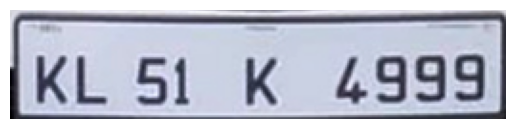

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

# Ana görüntüyü yükle
img = Image.open('test_data/test.jpeg')

# Tespit edilen her bir bounding box'ı işle
for idx, result in enumerate(test_result):
    boxes = result.boxes.xyxy  # Her bir sonuçtaki kutuları al
    
    for box in boxes:
        xmin, ymin, xmax, ymax = map(int, box[:4])  # İlk 4 eleman koordinatları temsil eder

        # Resmi kırp
        cropped_img = img.crop((xmin, ymin, xmax, ymax))
        
        # Kırpılan resmi kaydet
        cropped_img.save(f'cropped_objects/cropped_object_{idx}.jpg')  # Her bir nesne için farklı dosya adı
        
        # Kırpılan resmi ekrana bastır
        plt.imshow(cropped_img)
        plt.axis('off')  # Eksenleri kapat
        plt.show()


In [25]:
# YOLO İLE TESPİT EDİLEN PLAKA KAYDEDİLİR VE DÖNDÜRÜLÜR 

def crop_save_and_display_objects(img, test_result, save_dir='cropped_objects'):
    """
    Ana görüntüden tespit edilen bounding box'lara göre kırpma yapar, her bir kırpılan nesneyi kaydeder 
    ve orijinal görüntüyle birlikte yan yana gösterir.

    Parameters:
    img (PIL.Image): Kırpılacak ana görüntü.
    test_result (list): Her bir sonucu içeren bounding box'ları içeren liste.
    save_dir (str): Kırpılan görüntülerin kaydedileceği klasör adı.
    """
    # Klasör mevcut değilse oluştur
    os.makedirs(save_dir, exist_ok=True)

    # Tespit edilen her bir bounding box'ı işle
    for idx, result in enumerate(test_result):
        boxes = result.boxes.xyxy  # Her bir sonuçtaki kutuları al

        for box_idx, box in enumerate(boxes):
            xmin, ymin, xmax, ymax = map(int, box[:4])  # İlk 4 eleman koordinatları temsil eder

            # Resmi kırp
            cropped_img = img.crop((xmin, ymin, xmax, ymax))
            
            # Kırpılan resmi kaydet
            cropped_img.save(f'{save_dir}/cropped_object_{idx}_{box_idx}.jpg')  # Her bir nesne için farklı dosya adı
            
            # Resimleri yan yana göstermek için subplot oluştur
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            
            # Orijinal resmi göster
            axes[0].imshow(img)
            axes[0].set_title("Original Image")
            axes[0].axis('off')
            
            # Kırpılan resmi göster
            axes[1].imshow(cropped_img)
            axes[1].set_title(f"Cropped Object {idx}_{box_idx}")
            axes[1].axis('off')
            
            # Görüntüleri ekrana bastır
            plt.show()

    return cropped_img

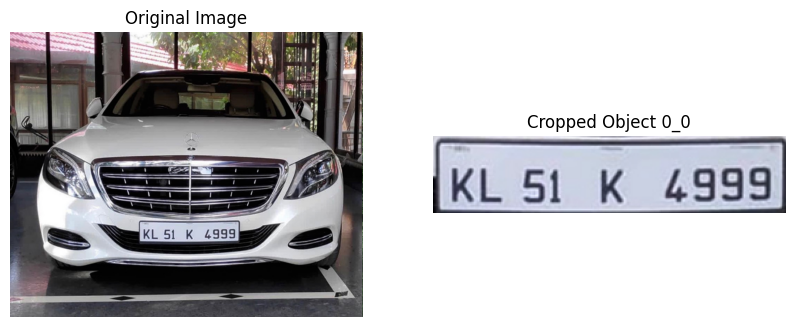

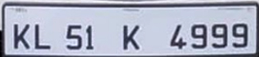

In [26]:
crop_save_and_display_objects(img,test_result )

### OCR ile Yazıları Tespit Etme 

In [27]:
ocr_motor = ocr.Reader(['en', 'tr'])  
# Reader classının içinde detect(yazıyı tespit eder) ve recognizing(yazıyı tanır) modülleri yer alır. 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


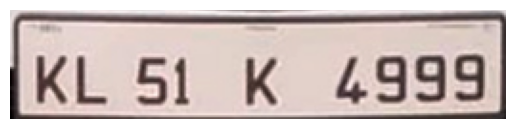

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Kırpılmış resmi numpy dizisine çevir
cropped_img_np = np.array(cropped_img)

# OpenCV formatına dönüştür (BGR'ye dönüştürme işlemi)
cropped_img_cv2 = cv2.cvtColor(cropped_img_np, cv2.COLOR_RGB2BGR)

# Matplotlib ile görüntüyü gösterme
plt.imshow(cropped_img_cv2)
plt.axis('off')  # Eksenleri gizle
plt.show()


In [29]:
# Kırpılmış resmi numpy dizisine çevir
cropped_img_np = np.array(cropped_img)

# OpenCV formatına dönüştür (BGR'ye dönüştürme işlemi)
cropped_img_cv2 = cv2.cvtColor(cropped_img_np, cv2.COLOR_RGB2BGR)

# OCR ile metin tanıma
plate = ocr_motor.readtext(cropped_img_cv2)
print(plate)
# Tanınan metni yazdır
for (bbox, text, prob) in plate:
    print(f'Tanımlanan Metin: {text}, Güven: {prob}')


[([[6, 18], [101, 18], [101, 57], [6, 57]], 'KL 51', 0.9162040554876945), ([[116, 22], [148, 22], [148, 56], [116, 56]], 'K', 0.9979388616688176), ([[165, 17], [255, 17], [255, 55], [165, 55]], '4999', 0.9936338663101196)]
Tanımlanan Metin: KL 51, Güven: 0.9162040554876945
Tanımlanan Metin: K, Güven: 0.9979388616688176
Tanımlanan Metin: 4999, Güven: 0.9936338663101196


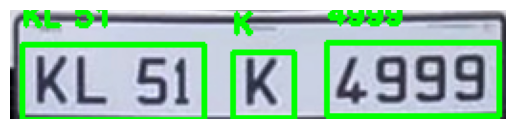

In [30]:
# Tespit edilen metin kutularını çiz
for (bbox, text, prob) in plate:
    # bbox: [sol üst, sağ üst, sağ alt, sol alt]
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))
    
    # Dikdörtgeni çiz
    cv2.rectangle(cropped_img_cv2, top_left, bottom_right, (0, 255, 0), 2)
    # Metni yaz
    cv2.putText(cropped_img_cv2, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# OpenCV, BGR formatında okur, bunu RGB formatına çevirmek gerekli
img_rgb = cv2.cvtColor(cropped_img_cv2, cv2.COLOR_BGR2RGB)

# Matplotlib ile görüntüyü göster
plt.imshow(img_rgb)
plt.axis('off')  # Eksenleri gizle
plt.show()

In [31]:
# resimdeki yazıları yan yana yazdırır
result = ' '.join([letters[1] for letters in plate])
print(result)

KL 51 K 4999


In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def perform_ocr_on_cropped_image(cropped_img, ocr_motor):
    """
    Kırpılmış bir PIL görüntüsü üzerinde OCR işlemi yapar, tespit edilen metin kutularını çizer,
    görüntüyü ekranda gösterir ve tanınan metinleri birleştirerek döndürür.

    Parameters:
    ----------
    cropped_img : PIL.Image
        OCR işlemi yapılacak kırpılmış ana görüntü.
    ocr_motor : obj
        OCR motoru nesnesi (örneğin, EasyOCR Reader).

    Returns:
    -------
    str
        Tespit edilen tüm metinlerin birleştirilmiş hali.
    """
    # Kırpılmış resmi NumPy dizisine çevir
    cropped_img_np = np.array(cropped_img)
    
    # OpenCV formatına dönüştür (RGB'den BGR'ye)
    cropped_img_cv2 = cv2.cvtColor(cropped_img_np, cv2.COLOR_RGB2BGR)
    
    # OCR ile metin tanıma
    plate = ocr_motor.readtext(cropped_img_cv2)
    
    # Tanınan metinleri yazdır
    for (bbox, text, prob) in plate:
        print(f'Tanımlanan Metin: {text}, Güven: {prob:.2f}')
    
    # Tespit edilen metin kutularını çiz
    for (bbox, text, prob) in plate:
        # bbox: [sol üst, sağ üst, sağ alt, sol alt]
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        
        # Dikdörtgeni çiz
        cv2.rectangle(cropped_img_cv2, top_left, bottom_right, (0, 255, 0), 2)
        # Metni yaz
        cv2.putText(cropped_img_cv2, text, (top_left[0], top_left[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # OpenCV, BGR formatında okur, bunu RGB formatına çevirmek gerekli
    img_rgb = cv2.cvtColor(cropped_img_cv2, cv2.COLOR_BGR2RGB)
    
    # Metin kutuları çizilmiş resmi göster
    plt.imshow(img_rgb)
    plt.axis('off')  # Eksenleri gizle
    plt.show()
    
    # Resimdeki yazıları yan yana yazdır
    result = ' '.join([text for (_, text, _) in plate])
    print(f'Tespit Edilen Metinler: {result}')
    
    return result


Tanımlanan Metin: KL 51, Güven: 0.92
Tanımlanan Metin: K, Güven: 1.00
Tanımlanan Metin: 4999, Güven: 0.99


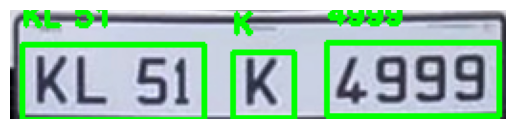

Tespit Edilen Metinler: KL 51 K 4999


'KL 51 K 4999'

In [33]:
perform_ocr_on_cropped_image(cropped_img, ocr_motor)

### Elde Edilen Yazının Veritabanına Kaydedilmesi

In [34]:
import sqlite3

# Veritabanına bağlanma (dosya yoksa oluşturulur)
conn = sqlite3.connect('database/plate_database1.db')
c = conn.cursor()

# Tabloyu oluşturma
c.execute('''
    CREATE TABLE IF NOT EXISTS plakalar (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        Plate TEXT NOT NULL
    )
''')

conn.commit()


In [35]:
# Plaka metnini birleştirip veritabanına eklemek
plate_text = ' '.join([letters[1] for letters in plate])
plate_text

'KL 51 K 4999'

In [36]:
# Veriyi tabloya ekleme
c.execute("INSERT INTO plakalar (Plate) VALUES (?)", (plate_text,))

# Değişiklikleri kaydetme
conn.commit()

print("Plaka başarıyla veritabanına kaydedildi!")

Plaka başarıyla veritabanına kaydedildi!


In [37]:
import sqlite3

# Veritabanına bağlanma
conn = sqlite3.connect('database/plate_database1.db')
c = conn.cursor()

# Veritabanındaki tüm plakaları sorgulama
c.execute("SELECT * FROM plakalar")

# Sonuçları çekme ve ekrana yazdırma
rows = c.fetchall()

for row in rows:
    print(row)

# Bağlantıyı kapatma
conn.close()


(1, 'KL 51 K 4999')


In [44]:
# VERİ TABANINA KAYDETME 
def save_plate(db_name, plate_text):
    """
    Verilen plaka değerini veritabanına kaydeder. Aynı değerden varsa kaydetmez.

    Parameters:
    db_name (str): Veritabanının dosya adı (örneğin, 'database/plate_database1.db').
    plate_text (str): Kaydedilecek plaka metni.
    """
    # Veritabanına bağlan
    conn = sqlite3.connect(db_name)
    c = conn.cursor()
    
    # Aynı plaka değeri var mı diye kontrol et
    c.execute("SELECT 1 FROM plakalar WHERE Plate = ?", (plate_text,))
    result = c.fetchone()
    
    # Eğer sonuç None ise, plaka mevcut değil, kaydedebiliriz
    if result is None:
        c.execute("INSERT INTO plakalar (Plate) VALUES (?)", (plate_text,))
        conn.commit()
        print(f"'{plate_text}' veritabanına kaydedildi.")
    else:
        print(f"'{plate_text}' zaten veritabanında mevcut, kaydedilmedi.")
    
    # Bağlantıyı kapat
    conn.close()

# Örnek kullanım
db_name = 'database/plate_database1.db'
save_plate(db_name, plate_text)


'KL 51 K 4999' zaten veritabanında mevcut, kaydedilmedi.


In [38]:
# VERİ TABANI OLUŞTURMA 
def create_database(db_name):
    """
    Veritabanını verilen isimle oluşturur, eğer mevcut değilse.
    
    Parameters:
    db_name (str): Veritabanının dosya adı (örneğin, 'database/plate_database1.db').
    """
    # Veritabanı dosyasının var olup olmadığını kontrol et
    if not os.path.exists(db_name):
        # Veritabanına bağlanma (dosya yoksa oluşturulur)
        conn = sqlite3.connect(db_name)
        c = conn.cursor()
        
        # Tabloyu oluşturma
        c.execute('''
            CREATE TABLE IF NOT EXISTS plakalar (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                Plate TEXT NOT NULL
            )
        ''')
        
        conn.commit()
        conn.close()
        print(f"Veritabanı '{db_name}' oluşturuldu.")
    else:
        print(f"Veritabanı '{db_name}' zaten mevcut.")

# Veritabanı dosya ismini değişken olarak belirtin
db_name = 'database/plate_database1.db'
create_database(db_name)

Veritabanı 'database/plate_database1.db' zaten mevcut.


## VİDEO İLE TEST

In [39]:
import cv2
import os
from ultralytics import YOLO

In [40]:
model = YOLO('runs/detect/train6/weights/best.pt')

In [41]:
# Sınıf isimlerini ve ID'lerini kontrol edin
print(model.names)

{0: 'LicensePlate'}


In [42]:
# Video dosyasını aç
video_path = 'test_data/Car_Traffic_short.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Video dosyası yüklenemedi.")
else:
    print("Video dosyası yüklendi.")

Video dosyası yüklendi.


In [43]:
test_vid = model.predict(source='test_data/Car_Traffic_short.mp4', save=True, save_crop=True, save_dir='detected_plates')



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/2880) c:\Users\havva\OneDrive\Desktop\plaka_tanima\test_data\Car_Traffic_short.mp4: 384x640 (no detections), 123.5ms
video 1/1 (frame 2/2880) c:\Users\havva\OneDrive\Desktop\plaka_tanima\test_data\Car_Traffic_short.mp4: 384x640 (no detections), 195.2ms
video 1/1 (frame 3/2880) c:\Users\havva\OneDrive\Desktop\plaka_tanima\test_data\Car_Traffic_short.mp4: 384x640 (no detections), 154.9ms
video 1/1 (frame 4/2880) c:\Users\havva\OneDrive\D

KeyboardInterrupt: 

#### OCR ile dosyadaki görüntülerden plakaları çıkarma

In [ ]:
ocr_motor = ocr.Reader(['en', 'tr'])  
# Reader classının içinde detect(yazıyı tespit eder) ve recognizing(yazıyı tanır) modülleri yer alır. 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [ ]:

def ocr_process_with_cropped_images(crop_dir):
    # Daha önce kaydedilen yazılar
    recognized_texts = set()  # aynı veriyi bir daha kaydetmez
    recognized_texts_list = []  # Metinlerin kaydedileceği liste

    # Kırpılmış görüntülerin bulunduğu dizini kontrol et
    for filename in os.listdir(crop_dir):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Kırpılmış resmi numpy dizisine çevir
            cropped_img = cv2.imread(os.path.join(crop_dir, filename))

            # OpenCV formatına dönüştür
            cropped_img_cv2 = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

            # OCR ile metin tanıma
            plate = ocr_motor.readtext(cropped_img_cv2)
            
            print(plate)

            # Plaka metnini birleştirip veritabanına eklemek
            plate_text = ' '.join([letters[1] for letters in plate])
            plate_text
            recognized_texts.add(plate_text)
            recognized_texts_list.append(plate_text)  # Benzersiz metni listeye ekle
            print(f'Tanımlanan Plaka: {plate_text}')

            for (bbox, text, prob) in plate:
                if text not in recognized_texts:
                    recognized_texts.add(text)
                    recognized_texts_list.append(text)  # Benzersiz metni listeye ekle
                    print(f'Tanımlanan Metin: {text}, Güven: {prob}')

    return recognized_texts  # Benzersiz metinlerin listesini döndür

# Kullanım
recognized_plates = ocr_process_with_cropped_images('runs/detect/predict3/crops/LicensePlate')

# Tanınan plakaları yazdır
print("Tanınan Plakalar:", recognized_plates)
